# Hi! Lets try!

version 0.3
Tsurkan Viacheslav

#### Some libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Import some data

In [2]:
#,index_col="id"
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#### Overview our data.

In [3]:
print(train_df.columns.values)
train_df[:5]

['id' 'text' 'author']


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
test_df[:5]

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


##### Shape and data type.

In [5]:
#train_df = train_df.drop(['id'],axis=1)
print(train_df.shape)
print(test_df.shape)

(19579, 3)
(8392, 2)


In [6]:
train_df[["author","text"]].groupby(["author"]).count()/train_df.shape[0]

,text
author,
EAP,0.403494
HPL,0.287808
MWS,0.308698


Start

In [7]:
X = train_df.text
y = train_df.author


In [8]:
y.shape

(19579,)

In [9]:
T = test_df.text


In [10]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [11]:
#http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

from sklearn.feature_extraction.text import TfidfVectorizer

#Extracting features from the training data using a sparse vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1, 3))
X_train = vectorizer.fit_transform(X1_train)
#Extracting features from the test data using the same vectorizer
X_test = vectorizer.transform(X1_test)

X_full = vectorizer.transform(X)
T_test = vectorizer.transform(T)

In [12]:
feature_names = vectorizer.get_feature_names()
len(feature_names)

322805

In [13]:
from sklearn.neural_network import MLPClassifier

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics

from time import time
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    #scores = cross_val_score(clf, X_full, y, cv=10, scoring='accuracy')
    train_time = time() - t0
    #print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    #print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    #score = scores.mean()
    print("accuracy:   %0.4f" % score)
    
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
         (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
         (Perceptron(max_iter=50), "Perceptron"),
         (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive")):
    
    
     results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))
    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty=penalty)))



results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty="elasticnet")))
results.append(benchmark(NearestCentroid()))
# results.append(benchmark(MLPClassifier()))

results.append(benchmark(MultinomialNB(alpha=.01,fit_prior=True)))
# results.append(benchmark(MultinomialNB(alpha=.06,fit_prior=False)))
# results.append(benchmark(MultinomialNB(alpha=.10)))
# results.append(benchmark(MultinomialNB(alpha=.11)))

# results.append(benchmark(BernoulliNB(alpha=.01)))

# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))



________________________________________________________________________________
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
accuracy:   0.8085

________________________________________________________________________________
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)
accuracy:   0.7937

________________________________________________________________________________
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=50, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
accuracy:   0.8108

_____________________________________________________________________

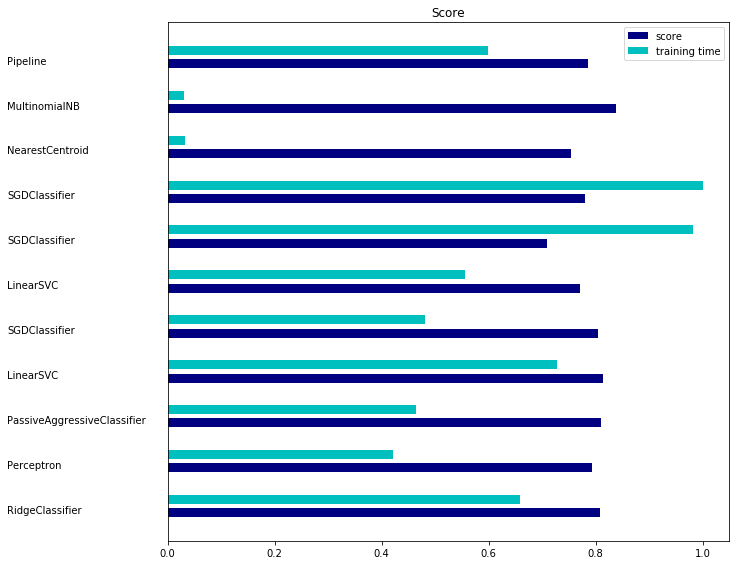

In [16]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time", color='c')
#plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [17]:
results

[['RidgeClassifier',
  'Perceptron',
  'PassiveAggressiveClassifier',
  'LinearSVC',
  'SGDClassifier',
  'LinearSVC',
  'SGDClassifier',
  'SGDClassifier',
  'NearestCentroid',
  'MultinomialNB',
  'Pipeline'],
 [0.80847803881511748,
  0.79366700715015326,
  0.81077630234933606,
  0.81435137895812049,
  0.80464759959141985,
  0.77068437180796734,
  0.70863125638406532,
  0.77987742594484166,
  0.75408580183861085,
  0.83810010214504593,
  0.78626149131767109],
 [1.6119003295898438,
  1.031397819519043,
  1.1375703811645508,
  1.7787361145019531,
  1.1758074760437012,
  1.3583483695983887,
  2.402785062789917,
  2.4459519386291504,
  0.07851624488830566,
  0.07499814033508301,
  1.4644389152526855],
 [0.005998849868774414,
  0.009999513626098633,
  0.0064907073974609375,
  0.001499176025390625,
  0.009998559951782227,
  0.0009999275207519531,
  0.007001161575317383,
  0.006497859954833984,
  0.015485763549804688,
  0.0060002803802490234,
  0.014510154724121094]]

#### bgbyyyuu

In [18]:
from sklearn.calibration import CalibratedClassifierCV


In [19]:


# instantiate the model with the best known parameters
bestmodel = MultinomialNB(alpha=.01)

#RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
#         max_iter=None, normalize=False, random_state=None, solver='sag',
#         tol=0.01)


# MultinomialNB(alpha=.06,fit_prior=True)
#MultinomialNB(alpha=.01)

#BernoulliNB(alpha=.01)

# train the model with X and y (not X_train and y_train)
# svm = bestmodel
# clf = CalibratedClassifierCV(svm)
# clf.fit(X_full, y)
# result = clf.predict_proba(T_test)

bestmodel.fit(X_full, y)
 
#make a prediction for an out-of-sample observation
#predict_proba
result = bestmodel.predict_proba(T_test)
bestmodel.predict(T_test)


array(['MWS', 'EAP', 'EAP', ..., 'EAP', 'MWS', 'HPL'], 
      dtype='<U3')

In [20]:
result

array([[  8.65491046e-02,   2.01350772e-02,   8.93315818e-01],
       [  9.62200933e-01,   1.09178987e-02,   2.68811679e-02],
       [  5.49230435e-01,   4.47965703e-01,   2.80386162e-03],
       ..., 
       [  9.99978342e-01,   6.77641667e-06,   1.48812571e-05],
       [  3.17193583e-02,   2.85171003e-03,   9.65428932e-01],
       [  4.46125899e-02,   9.55036873e-01,   3.50537001e-04]])

In [21]:
# row_sums = result.sum(axis=1)
# result_normalized = result / row_sums[:, np.newaxis]

In [22]:
df = pd.DataFrame(result, test_df.id, columns=["EAP","HPL","MWS"])

In [23]:
df

,EAP,HPL,MWS
id,,,
id02310,8.654910e-02,0.020135,0.893316
id24541,9.622009e-01,0.010918,0.026881
id00134,5.492304e-01,0.447966,0.002804
id27757,9.186226e-01,0.080921,0.000456
id04081,8.208663e-01,0.133898,0.045235
id27337,8.443068e-01,0.143921,0.011772
id24265,5.759623e-01,0.299406,0.124632
id25917,4.631928e-02,0.261646,0.692035
id04951,9.936762e-01,0.006279,0.000045


In [24]:
df.to_csv("Real2.csv")